In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook, trange, tqdm
from collections.abc import Iterable
from itertools import product
%matplotlib inline

In [4]:
matplotlib.rcParams.update({
    'font.size': 16,
})

## 1. Sample topology validation

In the numerical experiments we will use a simulation model, implemented in Python language, and available at [GitHub](https://github.com/larioandr/2019-dccn-sensors).

To get the numerical results, we assume that the expected time before sensor failure is 4000 hours, repair takes 24 hours in average and the network is considered failed after two or more nodes become unavailable.

Before running the numerical experiments, we need to validate the analytic and simulation models by comparing their results on the same topology, shown on fig. \ref{XXX}. However, to make the results more demonstrative, we will also assume that sensors are close enough to each other, so in case of the intermediate node failure the leaf node can reconnect to another one. The modified topology is shown on the fig. \ref{XXX}, where solid lines represent active connections, and a dashed line shows a possible alternative connection. 
  

In [5]:
FAILURE_RATE = 1/4000     # 4000 hours - mean interval between failures 
REPAIR_RATE = 1/24        # 24 hours - mean repair duration
CRITICAL_FAILURES = 2     # 2 - number of offline nodes till critical error
SIM_TIME_LIMIT = 50*12*30*24  # experiment duration is 50 years

/Users/andrey/workspace/2019-dccn-sensors/.venv/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


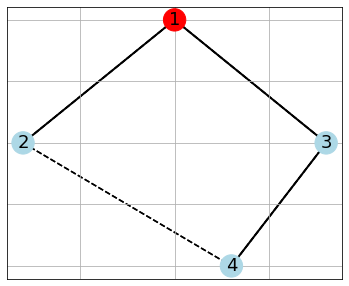

In [6]:
from senere.topology import Topology, GATEWAY_NODE, SENSOR_NODE
from senere.options import defaults as senere_defaults

senere_defaults['radio_range'] = 15.0  # This will simplify topology creation
senere_defaults['conn_line_width'] = 2.0
senere_defaults['neigh_line_width'] = 1.5

sample_topology = Topology()
sample_topology.nodes.add_from([
    {'address': 1, 'node_type': GATEWAY_NODE, 'x': 10.0, 'y': 25.0}, 
    {'address': 2, 'node_type': SENSOR_NODE, 'x': 2.0, 'y': 15.0},
    {'address': 3, 'node_type': SENSOR_NODE, 'x': 18.0, 'y': 15.0},
    {'address': 4, 'node_type': SENSOR_NODE, 'x': 13.0, 'y': 5.0},
])
sample_topology.connections.add_from([(3, 1), (2, 1), (4, 3)])

_, ax = plt.subplots(figsize=(6, 5))
ax.grid()
sample_topology.draw(neigh_edges=True, node_font_size=18, node_size=500, sensor_color='lightblue')

We analyze the stationary probability of the system failure, considering two scenarios:

1. after node 3 failure, node 4 doesn't reconnect to node 2, and
2. after node 3 failure, node 4 reconnects to node 2 (if it is available)

The first scenario is the same as the one considered in the analytic model, so we provide results from both simulation and analytic models, while analyzing the second scenario shows the advantage of making use of alternative connections. In both scenarios failures and repairs are assumed to be exponentially distributed. 

The results are shown in fig. \ref{XXX}.

In [7]:
from senere.simulation import simulate_network


def variate_failure_rates(topology, mean_failure_intervals, num_runs=1, routing=None, 
                          repair_interval=None, cons_repair_interval=None, 
                          num_critical_errors=2, stime_limit=None):
    """Runs an experiment with a given topology on different failure intervals.
    
    `topology` parameter may be either a `Topology` object instance, or a callable which
    returns a topology. In the second case, a new topology is used at each run, and the
    value at each point is an average overall runs.
    
    `cons_repair_interval` specifies a callable which returns a consequetive repair interval.
    If given, it is passed to the simulation, if not - use only `repair_interval`.
    
    Returns: a dictionary with routing mode keys ('static', 'dynamic') and array values
    with experiment results, each point correspond to mean failure interval.
    """
    # 1) Create topologies
    try:
        topologies = [topology() for _ in range(num_runs)]
    except TypeError:
        topologies = [topology for _ in range(num_runs)]
    
    # 2) Define repair intervals and routing:
    routing_modes = [routing] if routing is not None else ['static', 'dynamic']
    repair_interval = repair_interval or (lambda: np.random.exponential(1 / REPAIR_RATE))
    cons_repair_interval = cons_repair_interval or repair_interval
    stime_limit = stime_limit or SIM_TIME_LIMIT
    
    # 3) Run the experiment:
    result = {}
    for mode in tqdm_notebook(routing_modes, desc='Routing modes'):
        avg_operable = []
        for mfi in tqdm_notebook(mean_failure_intervals, desc='Mean failure intervals', leave=False):
            failure_interval = lambda: np.random.exponential(mfi)
            run_results = []
            if len(topologies) > 1:
                t_iter = tqdm_notebook(topologies, desc='Iterations', leave=False)
            else:
                t_iter = topologies
            for topology in t_iter:
                sim_ret = simulate_network(
                    topology, 
                    failure_interval=failure_interval, 
                    repair_interval=repair_interval,
                    cons_repair_interval=cons_repair_interval,
                    num_offline_till_repair=num_critical_errors,
                    routing_mode=mode,
                    stime_limit=stime_limit,
                )
                run_results.append(sim_ret.operable)
            avg_operable.append(np.average(run_results))
        result[mode] = avg_operable

    return result

In [8]:
MEAN_FAILURE_INTERVALS = np.arange(1, 101) * 24

exp_1a = variate_failure_rates(sample_topology, MEAN_FAILURE_INTERVALS)

['static', 'dynamic']


Text(0, 0.5, 'Probability')

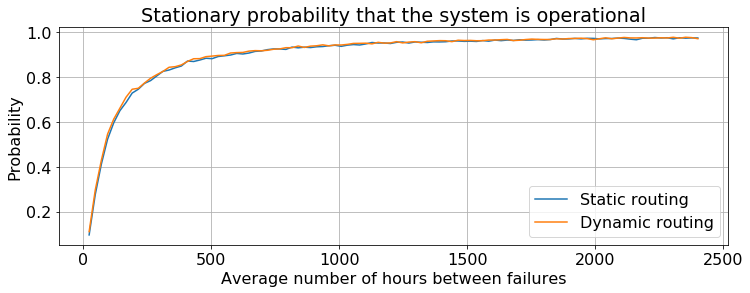

In [11]:
_, ax = plt.subplots(figsize=(12, 4))
ax.plot(MEAN_FAILURE_INTERVALS, exp_1a['static'], '-', label='Static routing')
ax.plot(MEAN_FAILURE_INTERVALS, exp_1a['dynamic'], '-', label='Dynamic routing')
ax.grid()
ax.legend()
ax.set_title('Stationary probability that the system is operational')
ax.set_xlabel('Average number of hours between failures')
ax.set_ylabel('Probability')

In [ ]:
def estimate_failed_trace(topology, num_runs, sample_interval=10, routing=None, 
                          failure_interval=None, repair_interval=None, cons_repair_interval=None, 
                          num_critical_errors=2, stime_limit=None):
    """Record traces for failed and offline nodes number.
    """
    # 1) Define parameters    
    routing_modes = [routing] if routing is not None else ['static', 'dynamic']
    failure_interval = failure_interval or (lambda: np.random.exponential(1 / FAILURE_RATE))
    repair_interval = repair_interval or (lambda: np.random.exponential(1 / REPAIR_RATE))
    cons_repair_interval = cons_repair_interval or repair_interval
    stime_limit = stime_limit or SIM_TIME_LIMIT
    
    # 2) Run experiments
    result = {}
    for routing_mode in tqdm_notebook(routing_modes, desc='Routing modes'):
        sim_ret = simulate_network(
            topology, 
            num_runs=num_runs,
            record_samples=True,
            sample_interval=sample_interval,
            failure_interval=failure_interval, 
            repair_interval=repair_interval,
            cons_repair_interval=cons_repair_interval,
            num_offline_till_repair=num_critical_errors,
            routing_mode=routing_mode,
            stime_limit=stime_limit,
        )
        record = {
            'failed': sim_ret.num_failed_sampled,
            'offline': sim_ret.num_offline_sampled,
        }
        result[routing_mode] = {}
        result[routing_mode]= 

    return result        

## 2. Forest topology

In the second experiment we study forest topologies, where a gateway is placed at the root of each tree.

In [ ]:
from senere.topology import build_forest_topology

forest_example = build_forest_topology(num_trees=2, arity=3, depth=3, dx=10, dy=50, roe=0.01, dt=14)

_, ax = plt.subplots(figsize=(20, 6))
ax.grid()
forest_example.draw(ax=ax, draw_neigh_edges=True)

In [ ]:
NUM_RUNS_2 = 1

mean_failure_intervals_2 = np.arange(1, 101) * 24

failure_rates = 1 / mean_failure_intervals_2

print('- Running experiment #2.1')

experiment_2_1 = [simulate_network(
    forest_example,
    failure_interval=lambda: np.random.exponential(1/r),
    repair_interval=lambda: np.random.exponential(1/REPAIR_RATE),
    num_offline_till_repair=CRITICAL_FAILURES,
    stime_limit=10*12*30*24,
    num_runs=NUM_RUNS_1,
    routing_mode='static',
) for r in tqdm_notebook(failure_rates)]

print('- Running experiment #2.2')

experiment_2_2 = [simulate_network(
    forest_example,
    failure_interval=lambda: np.random.exponential(1/r),
    repair_interval=lambda: np.random.exponential(1/REPAIR_RATE),
    num_offline_till_repair=CRITICAL_FAILURES,
    stime_limit=10*12*30*24,
    num_runs=NUM_RUNS_1,
    routing_mode='dynamic',
) for r in tqdm_notebook(failure_rates)]

print('= Finished')

In [ ]:
_, ax = plt.subplots(figsize=(12, 4))
ax.plot(mean_failure_intervals_2, [r.operable for r in experiment_2_1], label='No re-connection after failure')
ax.plot(mean_failure_intervals_2, [r.operable for r in experiment_2_2], label='Reconnecting after failure')
ax.grid()
ax.legend()
ax.set_title('Stationary probability that the system is operational')
ax.set_xlabel('Average number of hours between failures')
ax.set_ylabel('Probability')

In [ ]:
##### NUM_RUNS_1 = 2

def to_list(x):
    if not isinstance(x, Iterable):
        return [x]
    return x


def estimate_forest_operability(num_trees, arity, depth, failure_rate, routing_mode, num_critical_failures):
    dx = kwargs.get('dx', 10)
    dy = kwargs.get('dy', 50)
    roe = kwargs.get('roe', 0.01)
    dt = kwargs.get('dt', 14)
    
    num_trees = to_list(num_trees)
    arity = to_list(arity)
    depth = to_list(depth)
    failure_rate = to_list(failure_rate)
    routing_mode = to_list(routing_mode)
    num_critical_failures = to_list(num_critical_failures)
    
    parameters = product(num_trees, arity, depth, failure_rate, routing_mode, num_critical_failures)
    
    
    
    for _num_trees, _arity, _depth, _failure_rate, _routing_mode, _num_critical_failures in trange(parameters):
        topology
    
    
failure_rates = 1 / mean_failure_intervals_1

experiment_2_fixed = {
    'static': [
        simulate_network(
            build_forest_topology(num_trees=2, arity=3, depth=3, dx=10, dy=50, roe=0.01, dt=14),
            failure_interval=lambda: np.random.exponential(1/r),
            repair_interval=lambda: np.random.exponential(1/REPAIR_RATE),
            num_offline_till_repair=CRITICAL_FAILURES,
            stime_limit=SIM_TIME_LIMIT,
            num_runs=NUM_RUNS_2,
            routing_mode='static',
        ) for r in tqdm_notebook(failure_rates)],
    'dynamic': [simulate_network(
        build_forest_topology(num_trees=2, arity=3, depth=3, dx=10, dy=50, roe=0.01, dt=14),
        failure_interval=lambda: np.random.exponential(1/r),
        repair_interval=lambda: np.random.exponential(1/REPAIR_RATE),
        num_offline_till_repair=CRITICAL_FAILURES,
        stime_limit=SIM_TIME_LIMIT,
        num_runs=NUM_RUNS_2,
        routing_mode='static',
    ) for r in tqdm_notebook(failure_rates)],
}

## 3. Random topology

In the third experiment we consider completely random topologies.

In [ ]:
from senere.topology import build_random_topology

random_topology_example = build_random_topology(4, 100, radio_range=40, min_distance=20, 
                                                min_gw_distance=30, max_gw_distance=140)

_, ax = plt.subplots(figsize=(20, 10))
ax.grid()
random_topology_example.draw(ax=ax, draw_neigh_edges=True)